# Baseline Win Percentage Model

Binary Classification model to predict whether or not the away team will beat the home team in the next NLF game

### Config


In [1]:
cd ../../..

c:\Users\charl\Desktop\Git\nfl-model-store


c:\Users\charl\Desktop\Git\nfl-model-store\venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from src.data_registry import DataRegistry
from src.utils import get_dataframe
from src.modeling.utils import plot_correlation, train_test_splitter
from datetime import datetime
from sklearn.metrics import accuracy_score
import pandas as pd

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)


def df_rename_fold(df, t1_prefix, t2_prefix):
    '''
    The reverse of a df_rename_pivot
    Fold two prefixed column types into one generic type
    Ex: away_team_id and home_team_id -> team_id
    '''
    try:
        t1_all_cols = [i for i in df.columns if t2_prefix not in i]
        t2_all_cols = [i for i in df.columns if t1_prefix not in i]

        t1_cols = [i for i in df.columns if t1_prefix in i]
        t2_cols = [i for i in df.columns if t2_prefix in i]
        t1_new_cols = [i.replace(t1_prefix, '') for i in df.columns if t1_prefix in i]
        t2_new_cols = [i.replace(t2_prefix, '') for i in df.columns if t2_prefix in i]

        t1_df = df[t1_all_cols].rename(columns=dict(zip(t1_cols, t1_new_cols)))
        t2_df = df[t2_all_cols].rename(columns=dict(zip(t2_cols, t2_new_cols)))

        df_out = pd.concat([t1_df, t2_df]).reset_index().drop(columns='index')
        return df_out
    except Exception as e:
        print("--df_rename_fold-- " + str(e))
        print(f"columns in: {df.columns}")
        print(f"shape: {df.shape}")
        return df

START_SEASON = 2002
RUN_SEASON = 2023
RUN_WEEK = None

FEATURE_STORE_GROUP = "event"
FEATURE_STORE_NAME = "regular_season_game"
EXPERIMENT_NAME = "win_percentage"
RUN_NAME = "baseline"
METRIC = 'accuracy'
PRIMARY_METRIC_THRESHOLD = 0.65



DATA_COLUMNS = [
    'away_team_win',
    #'season', 
    #'week', 
    #'home_team', 
    #'away_team', 
    #'home_score', 
    #'away_score',
    'spread_line', 
    'total_line', 
    #'away_team_spread',
    #'total_target', 
    #'away_team_covered', 
    #'home_team_covered',
    #'under_covered', 
    #'away_team_covered_spread',
    'away_ewma_rushing_offense',
    'away_ewma_rushing_defense',
    'away_ewma_passing_offense',
    'away_ewma_passing_defense',
    'away_ewma_score_offense',
    'away_ewma_score_defense',
    'home_ewma_rushing_offense',
    'home_ewma_rushing_defense',
    'home_ewma_passing_offense',
    'home_ewma_passing_defense',
    'home_ewma_score_offense',
    'home_ewma_score_defense',
    #'away_rolling_spread_cover',
    #'away_rolling_under_cover',
    #'home_rolling_spread_cover', 
    #'home_rolling_under_cover',
    'away_elo_pre', 
    #'away_elo_prob', 
    'home_elo_pre', 
    #'home_elo_prob'
]

from src.data_registry import DataRegistry


data_registry = DataRegistry(feature_store_group=FEATURE_STORE_GROUP, feature_store_name=FEATURE_STORE_NAME)
df = data_registry.make_dataset(start_season=START_SEASON, end_season=RUN_SEASON)

### 1. Business Understanding

Binary Classification model to predict whether or not the away team will beat the home team in the next NLF game

We need to determine how accurate Vegas is in predicting whether or not the away team will beat the home team in the next NLF game. That will be our target accuracy. 

In [8]:
analysis_season = 2023

if 'home_team_win' in df.columns:
    df['away_team_win'] = df['home_team_win'].apply(lambda x: 1 if x == 0 else 0)
    df = df.drop(columns=['home_team_win'])

df['away_team_vegas_prediction'] = df['spread_line'].apply(lambda x: 1 if x < 0 else 0)

print(f"Vegas Accuracy 2000-2023 = {round(accuracy_score(df['away_team_win'], df['away_team_vegas_prediction']), 4) * 100}%")
print(f"Vegas Accuracy {analysis_season} = {round(accuracy_score(df[df['season'] == analysis_season]['away_team_win'], df[df['season'] == analysis_season]['away_team_vegas_prediction']), 4) * 100}%")

vegas_incorrect_df = df[(df['season'] == analysis_season) & (df['away_team_win'] != df['away_team_vegas_prediction'])].copy()
print(f"Vegas Incorrect Records {analysis_season} per week")
print(vegas_incorrect_df.groupby(['week'])['season'].count().reset_index().sort_values(by='season', ascending=False)[0:10])

print(f"Vegas Incorrect Records {analysis_season} per team")
folded_df = vegas_incorrect_df.copy()
folded_df['ishome'] = folded_df['home_team']
folded_df = df_rename_fold(folded_df, 'away_','home_')
folded_df = df_rename_fold(folded_df, '_away','_home')
folded_df = folded_df.drop_duplicates(['season','week','team'])
folded_df['ishome'] = folded_df['ishome'] == folded_df['team']
folded_df.groupby(['team'])['season'].count().reset_index().sort_values(by='season', ascending=False)

Vegas Accuracy 2000-2023 = 66.53999999999999%
Vegas Accuracy 2023 = 68.01%
Vegas Incorrect Records 2023 per week
    week  season
0      1       8
13    14       8
6      7       7
4      5       6
9     10       6
2      3       6
1      2       5
15    16       5
17    18       5
5      6       4
Vegas Incorrect Records 2023 per team


,team,season
26,PIT,9
22,NO,8
1,ATL,8
11,GB,8
12,HOU,7
21,NE,7
30,TEN,7
20,MIN,7
6,CIN,7
29,TB,7


### 2. Data Understanding

ELO ratings
- Rating system for teams to determine team strength
- Can be used for its own WP ratings but also an important feature

Estimated Points Added (EPA)
- Using play by play data determine the estimated points added for each team for a given matchup. We use a 10 game rolling average of rushing and passing EPA for offense and defense

Points Scored
- Total points scored by each team. Again we use a 10 game rolling average of points scored and points allowed

Target variable
- Away team score > Home team score

Team Cover
- Whether or not the away team is covered in the spread or total line in the last 10 games

Spread line
- Vegas spread line for the game

Total line
- Total point line for the game

In [4]:
# Data has already been prepared in the [feature store](https://github.com/theedgepredictor/nfl-feature-store)

### 3. Data Preparation

Data has already been prepared in the [feature store](https://github.com/theedgepredictor/nfl-feature-store)

We will use a train / test split of 2000-2022 seasons and 2023



In [5]:
import mlflow
import joblib
import os
def register_model(model, experiment_name, run_name):
    """
    Save the trained model to a specific directory.
    
    Parameters:
        model: The trained model (e.g., RandomForestClassifier).
        directory_path (str): Path to the directory where the model will be saved.
        file_name (str): The name of the file to save the model (default is 'model.pkl').
    
    Returns:
        str: The path where the model was saved.
    """
    # Ensure the directory exists
    output_dir = f"./src/experiments/{experiment_name}/{run_name}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the model as a pickle file
    model_path = os.path.join(output_dir, 'model.pkl')
    joblib.dump(model, model_path)
    print(f"Model saved at: {model_path}")
    
    return model_path

# Load the saved model
def load_registered_model(experiment_name, run_name):
    """
    Load a saved model from a specific directory.
    
    Parameters:
        directory_path (str): Path to the directory where the model is saved.
        file_name (str): The name of the saved model file (default is 'model.pkl').
    
    Returns:
        model: The loaded model.
    """
    output_dir = f"./src/experiments/{experiment_name}/{run_name}"
    model_path = os.path.join(output_dir, 'model.pkl')
    model = joblib.load(model_path)
    
    return model

def get_best_run(experiment_name, run_name, metric_key='accuracy'):
    """
    Get the best run with the highest accuracy where the run name is 'baseline'.
    
    Parameters:
        experiment_id (str): The MLflow experiment ID.
        metric_key (str): The key of the metric to rank runs by (default is 'accuracy').
    
    Returns:
        best_run (pd.Series): The best run with the highest accuracy.
    """
    # Query for runs with the name 'baseline'
    runs = mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id], 
                              filter_string=f"tags.mlflow.runName = '{run_name}'", 
                              order_by=[f"metrics.{metric_key} DESC"])
    
    # Get the best run (the first row will have the highest accuracy)
    if not runs.empty:
        best_run = runs.iloc[0]
        return best_run
    else:
        print(f"No runs found with the name '{run_name}'.")
        return None

In [6]:
from src.modeling.training.trainer import mlflow_trainer
mlflow_trainer(
    df=df,
    data_columns=DATA_COLUMNS,
    experiment_name=EXPERIMENT_NAME,
    run_name=RUN_NAME,
    metric=METRIC,
    metric_threshold=PRIMARY_METRIC_THRESHOLD,
    run_season=RUN_SEASON,
    run_week=RUN_WEEK,
    feature_store_group=FEATURE_STORE_GROUP,
    feature_store_name=FEATURE_STORE_NAME,
    model_class='RandomForestClassifier',
    start_season=START_SEASON,
    n_trials=75
)

c:\Users\charl\Desktop\Git\nfl-model-store\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No Successful runs found with the name 'baseline' using default threshold of 0.65.
MLFlow Run:
    experiment_id: 489090576060070207
    run_id: 71fe1505ef10409da180e087a4576fc6
    experiment_name: win_percentage
    run_name: baseline


2024/09/19 08:54:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


NEW BEST MODEL! Overwriting previous best model...


2024/09/19 08:54:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline at: http://127.0.0.1:8080/#/experiments/489090576060070207/runs/71fe1505ef10409da180e087a4576fc6.
2024/09/19 08:54:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/489090576060070207.


Model saved at: ./src/experiments/win_percentage/baseline\model.pkl
Model registered at: ./src/experiments/win_percentage/baseline\model.pkl


In [47]:


from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

mlflow.set_tracking_uri(uri='http://127.0.0.1:8080')

if mlflow.get_experiment_by_name(EXPERIMENT_NAME) is None:
    mlflow.create_experiment(name=EXPERIMENT_NAME)

mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

best_run = get_best_run(experiment_name=EXPERIMENT_NAME, run_name=RUN_NAME)
if best_run is not None:
    best_metric = best_run[f'metrics.{METRIC}']
    print(f"Best run to beat: {best_run['run_id']} with {METRIC} = {best_metric}")
else:
    print(f"No runs found with the name '{RUN_NAME}' using default threshold of {PRIMARY_METRIC_THRESHOLD}.")
    best_metric = PRIMARY_METRIC_THRESHOLD


with mlflow.start_run(run_name=RUN_NAME) as run:
    X_train, y_train, X_test, y_test, metadata_test = train_test_splitter(df, DATA_COLUMNS, start_season=START_SEASON, run_season=RUN_SEASON)

    mlflow.set_tags(
        {
            'data_features': DATA_COLUMNS,
            'feature_store_group': FEATURE_STORE_GROUP,
            'feature_store_name': FEATURE_STORE_NAME,
            'model_name': 'RandomForestClassifier',
            'run_season': RUN_SEASON,
            'run_week': RUN_WEEK,
            'start_season': START_SEASON,
            'task': 'BinaryClassification',
            'task_primary_metric': METRIC,
            'task_primary_metric_threshold': PRIMARY_METRIC_THRESHOLD,
        }
    )
    params = {
        'n_estimators': 500,
        #'class_weight': 'balanced',
        #'criterion': 'log_loss',
        #'max_depth': 15,
        'random_state': 0
    }

    mlflow.log_params(params)

    clf = RandomForestClassifier(**params)
    clf.fit(X_train, y_train)

    val_accuracy = accuracy_score(y_test, clf.predict(X_test))
    mlflow.log_metric(key=METRIC, value=val_accuracy)

    if val_accuracy > PRIMARY_METRIC_THRESHOLD:
        mlflow.sklearn.log_model(clf, 'model')
    else:
        print(f"Model accuracy: {val_accuracy} < {PRIMARY_METRIC_THRESHOLD}. Skipping model export.")

    if val_accuracy >= best_metric:
        print('NEW BEST MODEL! Overwriting previous best model...')
        
        saved_model_path = register_model(clf, experiment_name=EXPERIMENT_NAME, run_name=RUN_NAME)
        print(f"Model registered at: {saved_model_path}")
        
    mlflow.end_run()

No runs found with the name 'baseline'.
No runs found with the name 'baseline' using default threshold of 0.65.


2024/09/18 16:23:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


NEW BEST MODEL! Overwriting previous best model...


2024/09/18 16:23:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline at: http://127.0.0.1:8080/#/experiments/835843841987792904/runs/a2a9020e9e3c461ba870368843f6583c.
2024/09/18 16:23:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/835843841987792904.


Model saved at: ./src/experiments/win_percentage/baseline\model.pkl
Model registered at: ./src/experiments/win_percentage/baseline\model.pkl


In [7]:
clf = load_registered_model(experiment_name=EXPERIMENT_NAME, run_name=RUN_NAME)
clf

RandomForestClassifier(n_estimators=500, random_state=0)

### 4. Model Building



**Baseline Model**
- Random Forest Classifier with default parameters

Test Accuracy = 66.53999999999999%


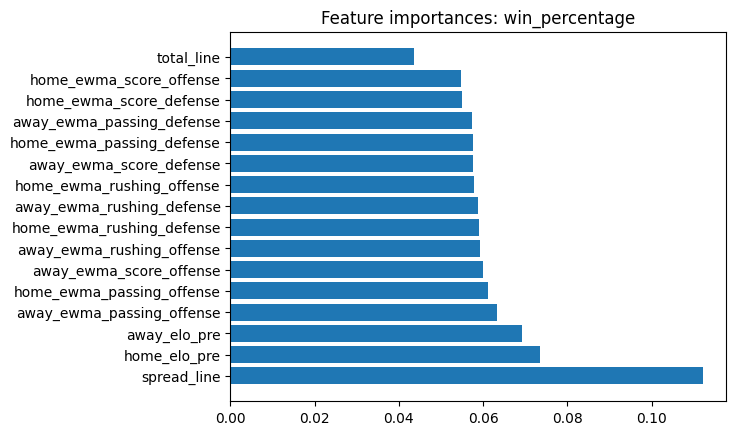

In [9]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
X_train, y_train, X_test, y_test, metadata_test = train_test_splitter(df, DATA_COLUMNS, start_season=START_SEASON, run_season=RUN_SEASON)
fig, ax = plt.subplots()
clf.fit(X_train, y_train)

print(f"Test Accuracy = {round(accuracy_score(y_test, clf.predict(X_test)), 4) * 100}%")

feature_importances = dict(zip(DATA_COLUMNS[1:], clf.feature_importances_))
feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
features_sorted = [feature for feature, _ in feature_importances]
coef_sorted = [coef for _, coef in feature_importances]

ax.set_title(f'Feature importances: {EXPERIMENT_NAME}')

ax.barh(features_sorted, coef_sorted)
plt.show()
plt.close()

### 5. Model Evaluation



In [10]:
meta_df = df[df['season'] == RUN_SEASON][['season','week','home_team','away_team', 'spread_line', 'away_team_win', 'away_team_vegas_prediction', 'away_elo_prob']].copy()
meta_df['away_team_win_percentage_prediction'] = clf.predict(X_test) # meta_df['away_elo_prob'].round().astype(int)

print(f"{EXPERIMENT_NAME}-{RUN_NAME} Accuracy {analysis_season} = {round(accuracy_score(meta_df['away_team_win'], meta_df['away_team_win_percentage_prediction']), 4) * 100}%")

model_incorrect_df = meta_df[(meta_df['season'] == analysis_season) & (meta_df['away_team_win'] != meta_df['away_team_win_percentage_prediction'])].copy()
print(f"{EXPERIMENT_NAME}-{RUN_NAME} Incorrect Records {RUN_SEASON} per week")
print(model_incorrect_df.groupby(['week'])['season'].count().reset_index().sort_values(by='season', ascending=False)[0:10])

print(f"{EXPERIMENT_NAME}-{RUN_NAME} Incorrect Records {RUN_SEASON} per team")
folded_df = model_incorrect_df.copy()
folded_df['ishome'] = folded_df['home_team']
folded_df = df_rename_fold(folded_df, 'away_','home_')
folded_df = df_rename_fold(folded_df, '_away','_home')
folded_df = folded_df.drop_duplicates(['season','week','team'])
folded_df['ishome'] = folded_df['ishome'] == folded_df['team']

print(folded_df.groupby(['team'])['season'].count().reset_index().sort_values(by='season', ascending=False))

model_incorrect_df[model_incorrect_df['week'] == 14]

win_percentage-baseline Accuracy 2023 = 66.53999999999999%
win_percentage-baseline Incorrect Records 2023 per week
    week  season
6      7       8
13    14       8
15    16       7
0      1       6
11    12       6
9     10       6
7      8       5
4      5       5
12    13       5
14    15       5
win_percentage-baseline Incorrect Records 2023 per team
   team  season
26  PIT       9
11   GB       9
6   CIN       8
21   NE       7
14  JAX       7
22   NO       7
29   TB       7
28   SF       7
1   ATL       7
20  MIN       7
18   LV       6
15   KC       6
31  WAS       6
12  HOU       6
9   DEN       6
25  PHI       6
2   BAL       6
24  NYJ       6
23  NYG       5
30  TEN       5
0   ARI       5
13  IND       5
10  DET       5
5   CHI       5
3   BUF       5
7   CLE       4
27  SEA       4
4   CAR       4
16   LA       4
19  MIA       3
17  LAC       3
8   DAL       2


,season,week,home_team,away_team,spread_line,away_team_win,away_team_vegas_prediction,away_elo_prob,away_team_win_percentage_prediction
5584,2023,14,PIT,NE,6.0,1,0,0.328238,0.0
5585,2023,14,ATL,TB,1.5,1,0,0.471295,0.0
5587,2023,14,CHI,DET,-3.0,0,1,0.636195,1.0
5591,2023,14,NYJ,HOU,-3.5,0,1,0.528138,1.0
5594,2023,14,KC,BUF,2.0,1,0,0.400897,0.0
5595,2023,14,LAC,DEN,3.0,1,0,0.395985,0.0
5597,2023,14,MIA,TEN,14.0,1,0,0.27904,0.0
5598,2023,14,NYG,GB,-6.0,0,1,0.581631,1.0


### 6. Model Deployment

Weekly or daily runs of registered models 

Predictions will be saved under ```./data/predictions/{experiment_name}/{run_name}/{run_season}.parquet```

Models will be re-fit for each run to make sure the latest data is used. If accuracy has dropped over the last couple weeks we can trigger a retrain against the registered model to try to gain more accuracy.

In [3]:
## Configure and setup an inference pipeline in the experiment folder of the project

from src.experiments.win_percentage.win_percentage import win_percentage_baseline_inference_pipeline
win_percentage_baseline_inference_pipeline()

Loading registered model: win_percentage/baseline
No predictions found for season 2022.
Loaded Predictions from 2022 - 0...
Generating Predictions for 2022 - 1...
Generating Predictions for 2022 - 2...
Generating Predictions for 2022 - 3...
Generating Predictions for 2022 - 4...
Generating Predictions for 2022 - 5...
Generating Predictions for 2022 - 6...
Generating Predictions for 2022 - 7...
Generating Predictions for 2022 - 8...
Generating Predictions for 2022 - 9...
Generating Predictions for 2022 - 10...
Generating Predictions for 2022 - 11...
Generating Predictions for 2022 - 12...
Generating Predictions for 2022 - 13...
Generating Predictions for 2022 - 14...
Generating Predictions for 2022 - 15...
Generating Predictions for 2022 - 16...
Generating Predictions for 2022 - 17...
Generating Predictions for 2022 - 18...
Saved predictions for season 2022 to ./data/predictions/win_percentage/baseline/2022.parquet
No predictions found for season 2023.
Loaded Predictions from 2023 - 0..

## 7. Model Monitoring / Results

In [6]:
from src.modeling.utils import get_predictions
fs_season_predictions_df = get_predictions(experiment_name=EXPERIMENT_NAME, run_name=RUN_NAME, season=2022)
#fs_season_predictions_df = fs_season_predictions_df[fs_season_predictions_df.week < 18]

pred_vals = fs_season_predictions_df.prediction > 0.5
true_vals = fs_season_predictions_df.away_team_win

print("Season Accuracy: ", accuracy_score(true_vals, pred_vals))

fs_season_predictions_df = fs_season_predictions_df.rename(columns={'prediction': f"{EXPERIMENT_NAME}_{RUN_NAME}_prediction"})

fs_season_predictions_df.head(10)

Season Accuracy:  0.6678966789667896


,home_team,away_team,season,week,away_team_win,win_percentage_baseline_prediction,model_uuid,updated_at
5120,LA,BUF,2022,1,1,0.438,71fe1505ef10409da180e087a4576fc6,2024-09-19 09:22:07.395323
5121,ATL,NO,2022,1,1,0.668,71fe1505ef10409da180e087a4576fc6,2024-09-19 09:22:07.395323
5122,CAR,CLE,2022,1,1,0.432,71fe1505ef10409da180e087a4576fc6,2024-09-19 09:22:07.395323
5123,CHI,SF,2022,1,0,0.704,71fe1505ef10409da180e087a4576fc6,2024-09-19 09:22:07.395323
5124,CIN,PIT,2022,1,1,0.306,71fe1505ef10409da180e087a4576fc6,2024-09-19 09:22:07.395323
5125,DET,PHI,2022,1,1,0.702,71fe1505ef10409da180e087a4576fc6,2024-09-19 09:22:07.395323
5126,HOU,IND,2022,1,0,0.804,71fe1505ef10409da180e087a4576fc6,2024-09-19 09:22:07.395323
5127,MIA,NE,2022,1,0,0.370,71fe1505ef10409da180e087a4576fc6,2024-09-19 09:22:07.395323
5128,NYJ,BAL,2022,1,1,0.696,71fe1505ef10409da180e087a4576fc6,2024-09-19 09:22:07.395323
5129,WAS,JAX,2022,1,0,0.272,71fe1505ef10409da180e087a4576fc6,2024-09-19 09:22:07.395323
